#### Import libraries

In [28]:
import sys
sys.path.append('BEHRT/Early_integration/')
sys.path.append('BEHRT/')

import pandas as pd
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
from torch.utils.data.dataset import Dataset
import os
import torch
import torch.nn as nn
import pytorch_pretrained_bert as Bert
import sklearn
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as skm
import math
import random
import time
import datetime 
from Utils.common import create_folder

from Utils.utils import age_vocab, input_vocab, mod_vocab, delay_vocab

from sklearn.metrics import roc_auc_score
from Utils import optimiser
from Utils.dataLoader_utils import ImbSampler, OverSampler, StratifiedSampler
from Utils.NextXVisit_v2 import NextVisit
from Models.BertForClassification import BertForClassification
import warnings
warnings.filterwarnings(action='ignore')
from collections import Counter
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import torch.nn.functional as F

from Utils.add_endpoints import add_endp
from Utils.handle_file import handle_file

hf = handle_file()

#### Utils 

In [29]:
def get_train_test_valid_idx(dataset):
    patient_idx = dataset.index
    
    train_idx = hf._load_pkl(file_config['train_idx'])
    train_idx = [idx for idx in train_idx if idx in patient_idx]

    test_idx = hf._load_pkl(file_config['test_idx'])
    test_idx = [idx for idx in test_idx if idx in patient_idx]

    valid_idx = hf._load_pkl(file_config['valid_idx'])
    valid_idx = [idx for idx in valid_idx if idx in patient_idx]
    
    return train_idx, test_idx, valid_idx

def split_data(dataset):
    train_idx, test_idx, valid_idx = get_train_test_valid_idx(dataset)
    
    
    train = dataset.loc[train_idx ,:]
    valid = dataset.loc[valid_idx ,:]
    test = dataset.loc[test_idx ,:]

    train = train.rename_axis('patid')
    valid = valid.rename_axis('patid')
    test = test.rename_axis('patid')

    train.reset_index(inplace=True)
    valid.reset_index(inplace=True)
    test.reset_index(inplace=True)

    train['patid'] = train['patid'].replace(train.patid.values,range(len(train.patid.values)))
    valid['patid'] = valid['patid'].replace(valid.patid.values,range(len(valid.patid.values)))
    test['patid'] = test['patid'].replace(test.patid.values,range(len(test.patid.values)))

    return train, test, valid 



In [30]:
## Plot results
def display_training_stats(data):
    import pandas as pd

    
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=data)
    
    # Display floats with two decimal places.
 #   pd.set_option('Average Train f1 score', 2)
 #   pd.set_option('Average Valid f1 score', 2)
 #   
    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')
    
 #   hf._dump_pkl(df_stats, 'training_stats')    
    # Display the table.
    return df_stats

def cal_mean(df_stats, feature, epochs):
    return [np.mean(df_stats.loc[x, feature]) for x in range(1,epochs+1)]

def cal_std(df_stats, feature, epochs):
    return [np.std(df_stats.loc[x, feature]) for x in range(1,epochs+1)]
     

def plot_history(training_stats, epochs):
    
    sn.set(style="whitegrid")
    fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (20,7))
    
    mean_f1_train = cal_mean(display_training_stats(training_stats), 'Average Train f1 score', epochs)
    std_f1_train = cal_std(display_training_stats(training_stats), 'Average Train f1 score', epochs)
    
    mean_f1_valid = cal_mean(display_training_stats(training_stats), 'Average Valid f1 score', epochs)
    std_f1_valid = cal_std(display_training_stats(training_stats), 'Average Valid f1 score', epochs)
    
    mean_loss_train = cal_mean(display_training_stats(training_stats), 'Training Loss', epochs)
    std_loss_train = cal_std(display_training_stats(training_stats), 'Training Loss', epochs)
    
    mean_loss_valid = cal_mean(display_training_stats(training_stats), 'Validation Loss', epochs)
    std_loss_valid = cal_std(display_training_stats(training_stats), 'Validation Loss', epochs)
    
    
    
    ax1.plot(range(epochs), mean_f1_train, 'b-', label='Train f1 score')
    ax1.fill_between(range(epochs), np.array(mean_f1_train) - np.array(std_f1_train), np.array(mean_f1_train) + np.array(std_f1_train), color='b', alpha=0.2)
    ax1.plot(range(epochs), mean_f1_valid, 'r--', label='Valid f1 score')
    ax1.fill_between(range(epochs), np.array(mean_f1_valid) - np.array(std_f1_valid), np.array(mean_f1_valid) + np.array(std_f1_valid), color='r', alpha=0.2)
   
    ax2.plot(range(epochs), mean_loss_train, 'b-', label='Train loss')
    ax2.fill_between(range(epochs), np.array(mean_loss_train) - np.array(std_loss_train), np.array(mean_loss_train) + np.array(std_loss_train), color='b', alpha=0.2)
    ax2.plot(range(epochs), mean_loss_valid, 'r--', label='Valid loss')
    ax2.fill_between(range(epochs), np.array(mean_loss_valid) - np.array(std_loss_valid), np.array(mean_loss_valid) + np.array(std_loss_valid), color='r', alpha=0.2)
   
    ax1.grid()
    ax2.grid()
    
    plt.legend()
    plt.show()
    return


def precision_test(logits, label):
    
    sig = nn.Sigmoid()
    output=sig(logits)
    label=np.argmax(label, axis=1).flatten().numpy()
    output=np.argmax(output, axis=1).flatten().numpy()
  #  output = np.argmax(np.where(output >= 0.5, 1, 0), axis=1).flatten()
    roc = sklearn.metrics.roc_auc_score(label ,output, average='samples')
    f1 =  sklearn.metrics.f1_score(label, output, average="macro")
    recall = sklearn.metrics.recall_score(label, output, average="macro")
    precision = sklearn.metrics.precision_score(label, output, average="macro")
 
    return f1, roc, recall, precision, output, label


def plot_roc_auc(fpr, tpr, roc_auc):
    
    import matplotlib.pyplot as plt
    import sklearn.metrics as metrics
    
   
    sn.set_style("whitegrid")
    fig,ax = plt.subplots(figsize=(13, 9))
    
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '#067062', label = 'AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.savefig('ROC_12.png')
    plt.show()

def cm(true, predicted, fig_name, cmap = 'Purples'):
    
    cm = confusion_matrix(true, predicted)

    df_cm = pd.DataFrame(cm)
    fig = plt.figure(figsize=(10,7))
    try:
        heatmap = sn.heatmap(df_cm, annot=True, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
   #fig.savefig(fig_name+'.png')
    return 

def print_report(model, data): 
     
    y = []
    y_label = []
    total_f1, total_roc, total_precision, total_recall = [], [], [], []
    model.eval()


    for step, batch in enumerate(data):


        age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch
       
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)

        age_ids = age_ids.to(global_params['device'])
        mod_ids = mod_ids.to(global_params['device'])
        del_ids = del_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])

        with torch.no_grad():
            outputs = model(input_ids, mod_ids, age_ids, del_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets, output_attentions=True)
        

        logits = outputs.logits.cpu()
        targets = targets.cpu()

        y_label.append(targets)
        y.append(logits)
        
    y_label = torch.cat(y_label, dim=0)
    y = torch.cat(y, dim=0)

     # Compute ROC curve and ROC area for each class
    f1, roc, recall, precision, output, label = precision_test(y, y_label)

    # Compute micro-average ROC curve and ROC area
    label = np.argmax(y_label, axis=1)
    sig = nn.Sigmoid()
    output=sig(y)

    fpr, tpr, _ = sklearn.metrics.roc_curve(label, output[:,1])
 #   fpr, tpr, _ = sklearn.metrics.roc_curve(label, y_label[:,1])
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    ## Plot ##  
    target_names = ['Non relapse', 'Relapse']

    print("f1 score is {:.4f}, Precision is {:.4f}, Recall is {:.4f}".format(f1, precision, recall))
    print(classification_report(label,  np.argmax(output, axis=1), target_names=target_names))
   # cm(label,  np.argmax(np.where(output >= 0.5, 1, 0), axis=1), 'cm')
    cm(label, np.argmax(output, axis=1), 'cm')
    
    plot_roc_auc(fpr, tpr, roc_auc)
  #  probs = F.softmax(y, dim=1).cpu().numpy()
  #  return probs, label
    return y_label, y, fpr, tpr, roc_auc  

#### Performing checks for the resources available

In [33]:
""" Check if the gpu is available """
if torch.cuda.is_available():
   
    device = torch.device("cuda")
    print("There are %d GPU(s) available. " %torch.cuda.device_count())
    print("We will use the GPU: {}".format(torch.cuda.get_device_name(0)))
    
else:
    print("No GPU available, using the CPU instead")
    device = torch.device("cpu")
    

There are 1 GPU(s) available. 
We will use the GPU: Tesla V100-PCIE-32GB


In [34]:
""" Empty the cache to enable the use of the gpu """

def empty_cuda():
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))
empty_cuda()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     512 B  |     512 B  |     512 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |     512 B  |     512 B  |     512 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |     512 B  |     512 B  |     512 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

#### Setting some configuration values

#### Run Binary classification 
1. Config

In [36]:
pretrain_model_path =  'BEHRT/Early_integration/Tasks/Output/MLM_mean.pkl'   # pretrained MLM path

file_config = { 'data':'BEHRT/Early_integration/Files/data_preprocessed_in_512_chunks_notherap_100.pkl',
                'labels' : 'BEHRT/Late_integration/Files/relapses.csv', 
                'train_idx' : 'BEHRT/Late_integration/Files/train_ids.pkl',
                'valid_idx' : 'BEHRT/Late_integration/Files/valid_ids.pkl',
                'test_idx' : 'BEHRT/Late_integration/Files/test_ids.pkl', 
                }

optim_config = {
    'lr': 5e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.1
}

global_params = {
    'batch_size': 32,
    'gradient_accumulation_steps': 1,
    'device': device,
    'output_dir': 'BEHRT/Early_integration/Tasks/Output', # output folder
    'best_name': 'clf_model_1',  # output model name
    'max_len_seq': 512, #100,
    'max_age': 110,
    'max_delay': 30, ## = 30years
    'age_month': 12,
    'delay_month': 0.25,
    'age_year': False,
    'age_symbol': None,
    'min_visit': 1,
}



feature_dict = {
    'word':True,
    'seg':True,
    'age':True,
    'modalities': True,
    'delays': True,
    'position': True
}

class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.delays_vocab_size = config.get('delays_vocab_size')
        self.modalities_vocab_size = config.get('modalities_vocab_size')
        self.age_vocab_size = config.get('age_vocab_size')
        self.seg_vocab_size = config.get('seg_vocab_size')
        self.output_attentions = config.get('output_attentions')
        self.chunk_size_feed_forward = config.get('chunk_size_feed_forward')
        self.is_decoder = config.get('is_decoder')
        self.layer_norm_eps = config.get('layer_norm_eps')
        self.add_cross_attention = config.get('add_cross_attention')
        

2. Import data 

In [37]:
"""Import train data """
data =  hf._load_pkl(file_config['data'])

"""Import labels """
labels = hf._load_csv(file_config['labels'])
labels.drop(['Unnamed: 0', 'status_drfs_5y'], axis='columns', inplace = True)
labels.rename(columns={'status_rfs_surg_5y': 'label'}, inplace=True)

"""Merge label and data """
data = pd.merge(data, labels, on=['Num_dossier'])
data.set_index('Num_dossier', inplace=True)

# Display 3 first rows
data.head(3)

,age_100_therap_removed_into_chunks_tolist,delays_100_therap_removed_into_chunks_tolist,modalities_100_therap_removed_into_chunks_tolist,inputs_quantiles_preprocessed_100_therap_removed_tolist,inputs_normal_range_preprocessed_100_therap_removed_tolist,inputs_curve_intersections_preprocessed_100_therap_removed_tolist,report,status_rfs,status_drfs,status_rfs_5y,status_rfs_surg_3y,status_drfs_surg_3y,label,status_drfs_surg_5y
Num_dossier,,,,,,,,,,,,,,
00002f6df9cfcb97985c88f5787ba874,"[61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[DEB, biologique, biologique, biologique, biol...","[CLS, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[CLS, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, ...","[CLS, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",[\nCorps du document\n\n\n\n\n\n\n\n\n\n16/07/...,0,0,0,0,0,0,0
00013328b341eedd7d4d788140b765a2,"[42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[DEB, biologique, biologique, biologique, biol...","[CLS, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[CLS, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[CLS, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[\nCorps du document\n\n\n\n\n\n\n\n\n\n\n23/0...,0,0,0,0,0,0,0
000ad3d5781425daf543e1cf0e099ec6,"[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[DEB, biologique, biologique, biologique, biol...","[CLS, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[CLS, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[CLS, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[\nCorps du document\n\nours en cours. Il s'a...,0,0,0,0,0,0,0


In [38]:
# remove patients with visits less than min visit
previous_shape = data.shape[0]

data['length'] = data['inputs_quantiles_preprocessed_100_therap_removed_tolist'].apply(lambda x: len([i for i in range(len(x)) if x[i] == 'SEP']))
data = data[data['length'] >= global_params['min_visit']]
#data = data.reset_index(drop=True)

print("We lost {} patient".format(previous_shape - data.shape[0]))

We lost 5 patient


In [39]:
## use the vocabulary from the MLM
whole_seq = hf._load_pkl('BEHRT/Early_integration/Files/whole_seq_preprocessed.pkl')
tokenVocab, _ = input_vocab(inputs = whole_seq.inputs_normal_range_preprocessed_100_therap_removed, symbol=global_params['age_symbol'])
ageVocab, _ = age_vocab(max_age=global_params['max_age'], mon = global_params['age_month'], symbol=global_params['age_symbol'])
modalitiesVocab, _ = mod_vocab(whole_seq.modalities_100_therap_removed, symbol=global_params['age_symbol'])
delayVocab, _ = delay_vocab(max_delay=global_params['max_delay'], mon = global_params['delay_month'], symbol=global_params['age_symbol'])

# Binary classification 
labelVocab = {0:0, 1:1}

In [73]:

model_config = {
    'vocab_size': len(tokenVocab), # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'modalities_vocab_size': len(modalitiesVocab), 
    'age_vocab_size': len(ageVocab), # number of vocab for age embedding
    'delays_vocab_size': len(delayVocab), 
    'max_position_embedding':global_params['max_len_seq'],  # maximum number of tokens
    'hidden_dropout_prob': 0.3, # dropout rate
    'num_hidden_layers': 24, # number of multi-head attention layers required
    'num_attention_heads': 24, # number of attention heads
    'attention_probs_dropout_prob': 0.3, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'chunk_size_feed_forward' : 0,
    'use_return_dict': True,
    'output_attentions': True,
    'output_hidden_states':True,
    'is_decoder': False,
    'layer_norm_eps' : 1e-12,  #1e-5
    'add_cross_attention' : False
}

3. Prepare data 

In [41]:
train, test, valid = split_data(data)

In [74]:
X_train = train['inputs_normal_range_preprocessed_100_therap_removed_tolist']
y_train = train['label']

Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=train, max_len=global_params['max_len_seq'], code='inputs_normal_range_preprocessed_100_therap_removed_tolist',
delay ='delays_100_therap_removed_into_chunks_tolist', age = "age_100_therap_removed_into_chunks_tolist", mod='modalities_100_therap_removed_into_chunks_tolist')
hp_generator = {'batch_size': global_params['batch_size'], 'balanced': 'balanced', 'shuffle':True}
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda:0' else {'num_workers': 5}
trainload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  sampler = StratifiedSampler(X_train, y_train, batch_size=global_params['batch_size']) , **kwargs)


In [75]:

Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=valid, max_len=global_params['max_len_seq'], code='inputs_normal_range_preprocessed_100_therap_removed_tolist',
 delay ='delays_100_therap_removed_into_chunks_tolist', age = "age_100_therap_removed_into_chunks_tolist", mod='modalities_100_therap_removed_into_chunks_tolist')
                 
validload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  shuffle = True, **kwargs)


In [76]:

Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=test, max_len=global_params['max_len_seq'], code='inputs_normal_range_preprocessed_100_therap_removed_tolist', delay ='delays_100_therap_removed_into_chunks_tolist'
                              , age = "age_100_therap_removed_into_chunks_tolist", mod='modalities_100_therap_removed_into_chunks_tolist' )
testload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  shuffle = False, **kwargs)


#### Handling class imbalance using sklearn's compute class weights

In [77]:
## Class weights

class_weights= sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(data.label),y=data.label)#.numpy())
class_weights = torch.FloatTensor(class_weights).cuda()

In [1]:
#class_weights = torch.FloatTensor([0.5, 50]).cuda()

NameError: name 'torch' is not defined

#### Model 
1. Utils



In [62]:
def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

In [63]:
def define_model(class_weights):
    
    # del model
    conf = BertConfig(model_config)
    model = BertForClassification(conf, num_labels=len(labelVocab.keys()), feature_dict=feature_dict, class_weights = class_weights)
    model = load_model(pretrain_model_path, model)   
    model = model.to(global_params['device'])
    optim = optimiser.adam(params=list(model.named_parameters()), config=optim_config)
    
    return model, optim

In [64]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=list(labelVocab.values()))
mlb.fit([[each] for each in list(labelVocab.values())])

MultiLabelBinarizer(classes=[0, 1])

In [65]:
## Scores 

import sklearn
def precision(output, label):
   # sig = nn.Sigmoid()
   # output=sig(logits)
    label, output = label.cpu(), output.detach().cpu()
    label=np.argmax(label, axis=1)
    output=np.argmax(output, axis=1)

    f1 =  sklearn.metrics.f1_score(label.numpy(), output.numpy(), average="macro")
    return f1, output, label

def precision_valid(output, label):
  #  sig = nn.Sigmoid()
   # output=sig(logits)
    label=np.argmax(label, axis=1)
    output=np.argmax(output, axis=1)   
    f1 =  sklearn.metrics.f1_score(label.numpy(), output.numpy(), average="macro")
    roc = sklearn.metrics.roc_auc_score(label.numpy(),output.numpy(), average='samples')
    
    
    return f1, roc, output, label

In [93]:

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

training_stats = []

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
   
def training(e, train_dataloader, valid_dataloader):
    
    start = time.time()
    
    # Reset the loss at each epoch
    temp_loss, temp_f1 = [], []
    train_f1, train_loss = [], []
    train_masks, train_targets =  [], []
    nb_tr_examples, nb_tr_steps = 0, 0
    ## Count the number of batches
    cnt = 0
    count = 0
    # Training
    model.train()
    

    for step, batch in enumerate(train_dataloader):
        
        cnt +=1
        age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch
 
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)
    
        ## Load batch to gpu 
        age_ids = age_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        mod_ids = mod_ids.to(global_params['device'])
        del_ids = del_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])
        
        
        ## Compute output (loss, logits and attentions scores) 
        output = model(input_ids, mod_ids, age_ids, del_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets, output_attentions = True)
      

        loss = output.loss
        logits  = output.logits
        attentions = output.attentions
        
        if global_params['gradient_accumulation_steps'] >1:
            loss = loss/global_params['gradient_accumulation_steps']
        
        loss.backward()
        

        temp_loss.append(loss.item())
        train_loss.append(loss.item())
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        
        f1, a, b = precision(logits, targets)
       
        temp_f1.append(f1)
   
        # Progress update every 1000 batches
        if step % 40 == 0:
            print("epoch: {}\t| Cnt: {}\t| Loss: {}\t| f1 score: {}".format(e, cnt, np.mean(temp_loss), np.mean(temp_f1)))
            temp_loss, temp_f1 = [], []
             
        
        if (step + 1) % global_params['gradient_accumulation_steps'] == 0:
  
            optim.step()
            optim.zero_grad()
            
        train_f1.append(f1)
        count+=1
        
 ## Features to plot hidden layers
        train_masks.append(attMask)
        train_targets.append(targets)
        
    train_hidden_states = output.hidden_states[1:]
    
  

        
    # Measure how long this epoch took.
    training_time = format_time(time.time() - start)
                   
    print("")
    print("Average training loss: {0:.2f}".format(np.mean(train_loss)))
    print("Average training score: {0:.2f}".format(np.mean(train_f1)))
    print("Training epoch took: {:}".format(training_time))
    
          
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    
    valid_f1, valid_roc, valid_loss, valid_time, valid_hidden_states, valid_masks, valid_targets = evaluation(valid_dataloader)
    
    # Record all statistics from this epoch.
    training_stats.append({'epoch': e+1, 
                               'Training Loss': np.mean(train_loss) ,
                               'Training Time' : training_time,
                               'Average Train f1 score' : np.mean(train_f1),
                               'Validation Loss': np.mean(valid_loss), 
                               'Validating Time' : valid_time, 
                               'Average Valid f1 score' : np.mean(valid_f1),
                           
                               'Average Valid ROC' : np.mean(valid_roc)
                                })  
        
    return valid_f1, train_f1, valid_loss, train_loss, valid_roc, training_stats, train_hidden_states, valid_hidden_states, train_masks, valid_masks, train_targets, valid_targets
    

def evaluation(data):
                               
    start = time.time()
                               
    model.eval()
    y = []
    y_label = []
    valid_masks, valid_targets = [], []
    val_loss, tot_f1, tot_roc = [], [], []
    
  #  total_f1, total_roc = 0, 0
    
    for step, batch in enumerate(data):
       
        age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)
     
        
        age_ids = age_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        mod_ids = mod_ids.to(global_params['device'])
        del_ids = del_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])
      
        with torch.no_grad():
            outputs = model(input_ids, mod_ids, age_ids, del_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets, output_attentions=True)
        
        val_loss.append(outputs.loss.item())
        
        logits = outputs.logits.cpu()
        
        targets = targets.cpu()
        
        y_label.append(targets)
        y.append(logits)
        
        valid_masks.append(attMask)
        valid_targets = y_label
        
    valid_hidden_states = outputs.hidden_states[1:]

    y_label = torch.cat(y_label, dim=0)
    y = torch.cat(y, dim=0) 
    
    tot_f1, tot_roc, output, label = precision_valid(y, y_label)
   
    # Measure how long this epoch took.
    validation_time = format_time(time.time() - start)
    
    
    print("Validation Loss: {0:.2f}".format(np.mean(val_loss)))
    print("Validation took: {:}".format(validation_time))
    print()

    
    return tot_f1, tot_roc, val_loss, validation_time, valid_hidden_states, valid_masks, valid_targets 


2. Training

In [94]:

if __name__=="__main__":
    
    # ========================================
    #               Training
    # ========================================
    
    start = time.time()


    # Let's set a seed value to make this reproducible
    set_seed(4)
   
    train_hidden_states_per_epoch, valid_hidden_states_per_epoch, train_masks_per_epoch, valid_masks_per_epoch = [], [] ,[], []  
    train_f1_list, train_loss_list = [], []
    valid_f1_list, valid_f1_list_tot, valid_loss_list, valid_roc_list = [], [], [], []
    best_pre = 0.0
    a = 0
    n = 5
    skf = StratifiedKFold(n_splits=n)
    
    train_skf = pd.concat([train, valid])
    
    positive_indexes = np.where(train_skf.label == 1)[0].tolist()
    negative_indexes = random.sample(np.where(train_skf.label == 0)[0].tolist(), len(positive_indexes))

    train_skf = train_skf[train_skf.index.isin(positive_indexes+negative_indexes)]
    
    X_tr_skf = train_skf['inputs_quantiles_preprocessed_100_therap_removed_tolist']
    y_tr_skf = train_skf['label']
    
    train_results, valid_results, valid_results_tot, train_loss, valid_loss, valid_results_roc, training_stats_list  = [], [], [], [], [], [], []
    

    for train_idx, cross_val_idx in skf.split(X_tr_skf, y_tr_skf):
       
        print("",end="\n\n")
        print(f"Generating Inputs for fold {a}")
        print("=="*20)
    
        train_df = train_skf.iloc[train_idx]
        train_df.index = range(train_df.shape[0])
        train_df.patid = range(train_df.shape[0])
        X_tr = train_df['inputs_quantiles_preprocessed_100_therap_removed_tolist']
        y_tr = train_df['label']
        
        
        cv_df = train_skf.iloc[cross_val_idx]
        cv_df.index = range(cv_df.shape[0])
        cv_df.patid = range(cv_df.shape[0])
        

        Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=train_df, max_len=global_params['max_len_seq'], code='inputs_normal_range_preprocessed_100_therap_removed_tolist', delay ='delays_100_therap_removed_into_chunks_tolist',
                          age = "age_100_therap_removed_into_chunks_tolist", mod='modalities_100_therap_removed_into_chunks_tolist')
        hp_generator = {'batch_size': global_params['batch_size'], 'balanced': 'balanced', 'shuffle':True}
        train_data = DataLoader(dataset=Dset, batch_size=global_params['batch_size'],  sampler = StratifiedSampler(X_tr, y_tr, batch_size=global_params['batch_size']) , **kwargs)
    
        
        valid_Dset = NextVisit(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab, age2idx=ageVocab, del2idx=delayVocab, dataframe=cv_df, max_len=global_params['max_len_seq'], code='inputs_normal_range_preprocessed_100_therap_removed_tolist', delay ='delays_100_therap_removed_into_chunks_tolist'
                              , age = "age_100_therap_removed_into_chunks_tolist", mod='modalities_100_therap_removed_into_chunks_tolist' )
        valid_data = DataLoader(dataset= Dset, batch_size=global_params['batch_size'],  shuffle = True, **kwargs)
        
        model, optim = define_model(class_weights)
        
        for e in range(5):   

            valid_f1, train_f1, valid_loss, train_loss, valid_roc, training_stats, train_hidden_states, valid_hidden_states, train_masks, valid_masks, train_targets, valid_targets =  training(e, train_data, valid_data)       

            train_hidden_states_per_epoch.append(train_hidden_states)
            valid_hidden_states_per_epoch.append(valid_hidden_states)
            
            train_masks_per_epoch.append(train_masks)
            valid_masks_per_epoch.append(valid_masks)
            
            train_f1_list.append(np.mean(train_f1))
            train_loss_list.append(np.mean(train_loss))
            valid_f1_list.append(np.mean(valid_f1))
            valid_roc_list.append(np.mean(valid_roc))
            valid_loss_list.append(np.mean(valid_loss))
            
            mean_f1 = np.mean(valid_f1)
            
            if mean_f1 > best_pre:
                # Save a trained model
                print("** ** * Saving fine - tuned model ** ** * ")
                model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
                output_model_file = os.path.join(global_params['output_dir'],global_params['best_name'])
                create_folder(global_params['output_dir'])

                torch.save(model_to_save.state_dict(), output_model_file)
                best_pre = mean_f1
            print('valid score: {}'.format(np.mean(valid_f1)))
          
            
            print()
        
        a+=1
        
    train_results.append(train_f1)
    valid_results.append(valid_f1)
    train_loss.append(train_loss)
    valid_loss.append(valid_loss)
    valid_results_roc.append(valid_roc)
    training_stats_list.append(training_stats)
    
        
    end = time.time()
    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(end-start)))

# age_ids, input_ids, mod_ids, del_ids, posi_ids, segment_ids, attMask, targets, _ = batch



Generating Inputs for fold 0


t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.6146149635314941	| f1 score: 0.5333333333333333
epoch: 0	| Cnt: 41	| Loss: 0.367574068903923	| f1 score: 0.346918798488164
epoch: 0	| Cnt: 81	| Loss: 0.2853700824081898	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 121	| Loss: 0.28292256519198417	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 161	| Loss: 0.2813507363200188	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 201	| Loss: 0.2805488854646683	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 241	| Loss: 0.2764103688299656	| f1 score: 0.3333333333333333

Average training loss: 0.30
Average training score: 0.34
Training epoch took: 0:00:19

Running Validation...
Validation Loss: 1.53
Validation took: 0:00:08

** ** * Saving fine - tuned model ** ** * 
valid score: 0.03938483674608939

epoch: 1	| Cnt: 1	| Loss: 0.2626330852508545	| f1 score: 0.3333333333333333
epoch: 1	| Cnt: 41	| Loss: 0.25735684037208556	| f1 score: 0.3731366732989151
epoch: 1	| Cnt: 81	| Loss: 0.2526109185069799	| f1 score: 0.4678270674

t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.6451284289360046	| f1 score: 0.4682306940371457
epoch: 0	| Cnt: 41	| Loss: 0.3769747830927372	| f1 score: 0.3408081798945378
epoch: 0	| Cnt: 81	| Loss: 0.2861452132463455	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 121	| Loss: 0.2828812263906002	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 161	| Loss: 0.2826559342443943	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 201	| Loss: 0.28189376667141913	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 241	| Loss: 0.2792745418846607	| f1 score: 0.3333333333333333

Average training loss: 0.30
Average training score: 0.33
Training epoch took: 0:00:18

Running Validation...
Validation Loss: 1.46
Validation took: 0:00:08

valid score: 0.03875790684301323

epoch: 1	| Cnt: 1	| Loss: 0.27366727590560913	| f1 score: 0.3333333333333333
epoch: 1	| Cnt: 41	| Loss: 0.2648925054818392	| f1 score: 0.34863775816897996
epoch: 1	| Cnt: 81	| Loss: 0.25582361593842506	| f1 score: 0.4140273465719094
epoch: 1	| Cnt: 121	| Loss: 0.24

t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.6531370878219604	| f1 score: 0.539313399778516
epoch: 0	| Cnt: 41	| Loss: 0.3764783337712288	| f1 score: 0.3456583426863049
epoch: 0	| Cnt: 81	| Loss: 0.2857988826930523	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 121	| Loss: 0.28333692625164986	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 161	| Loss: 0.28241193369030954	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 201	| Loss: 0.2823560208082199	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 241	| Loss: 0.2779344439506531	| f1 score: 0.3333333333333333

Average training loss: 0.30
Average training score: 0.34
Training epoch took: 0:00:18

Running Validation...
Validation Loss: 1.47
Validation took: 0:00:08

valid score: 0.03875790684301323

epoch: 1	| Cnt: 1	| Loss: 0.2627914547920227	| f1 score: 0.3333333333333333
epoch: 1	| Cnt: 41	| Loss: 0.2671628840267658	| f1 score: 0.3333333333333333
epoch: 1	| Cnt: 81	| Loss: 0.26038827151060107	| f1 score: 0.397974519140762
epoch: 1	| Cnt: 121	| Loss: 0.25286

t_total value of -1 results in schedule not being applied


epoch: 0	| Cnt: 1	| Loss: 0.644170343875885	| f1 score: 0.30980392156862746
epoch: 0	| Cnt: 41	| Loss: 0.37658472657203673	| f1 score: 0.34744376218073175
epoch: 0	| Cnt: 81	| Loss: 0.2858911193907261	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 121	| Loss: 0.28305707275867464	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 161	| Loss: 0.282222156226635	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 201	| Loss: 0.28316477611660956	| f1 score: 0.3333333333333333
epoch: 0	| Cnt: 241	| Loss: 0.28127356320619584	| f1 score: 0.3333333333333333

Average training loss: 0.30
Average training score: 0.34
Training epoch took: 0:00:19

Running Validation...
Validation Loss: 1.56
Validation took: 0:00:08

valid score: 0.03938030133458618

epoch: 1	| Cnt: 1	| Loss: 0.28083837032318115	| f1 score: 0.3333333333333333
epoch: 1	| Cnt: 41	| Loss: 0.28101684600114823	| f1 score: 0.3349812265331664
epoch: 1	| Cnt: 81	| Loss: 0.2756421506404877	| f1 score: 0.3349812265331664
epoch: 1	| Cnt: 121	| Loss: 0.

OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 31.75 GiB total capacity; 9.47 GiB already allocated; 69.69 MiB free; 10.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

3. Plot results 

In [ ]:
df_stats = display_training_stats(training_stats)
df_stats.tail()

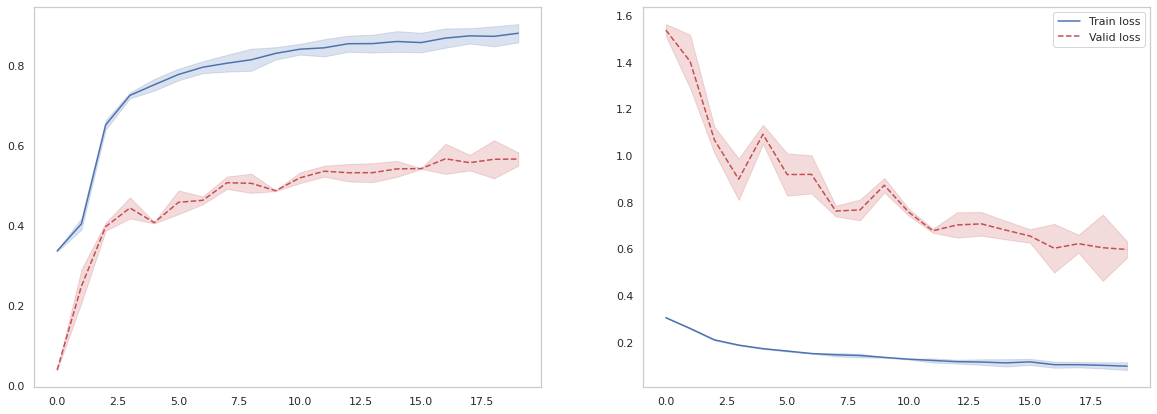

In [82]:
plot_history(training_stats, epochs = 5)

2. Display results

In [71]:
# Prediction on test set ## 2nd run , cv and cleaned

print('Predicting labels for {:,} test sequences...'.format(len(test)))
f1, roc, loss, test_time, test_hidden_states, test_masks, test_targets = evaluation(testload)
print('Test f1 score = {} and Test roc = {}'.format(np.mean(f1), np.mean(roc)))

Predicting labels for 4,483 test sequences...
Validation Loss: 1.27
Validation took: 0:00:05

Test f1 score = 0.48861369278430894 and Test roc = 0.5815310466896287


f1 score is 0.4792, Precision is 0.5239, Recall is 0.6194
              precision    recall  f1-score   support

 Non relapse       0.97      0.72      0.82      4288
     Relapse       0.08      0.52      0.13       195

    accuracy                           0.71      4483
   macro avg       0.52      0.62      0.48      4483
weighted avg       0.93      0.71      0.79      4483



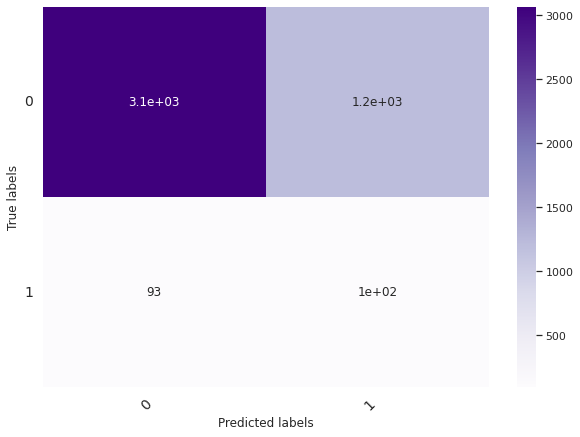

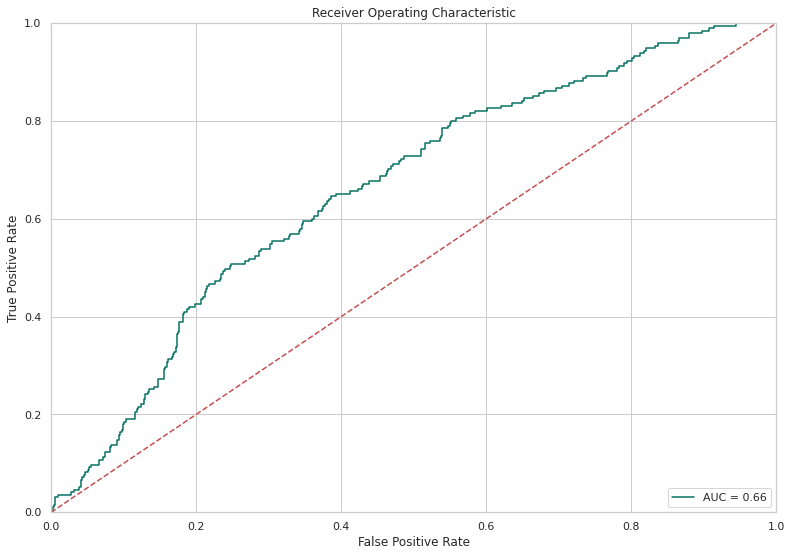

In [83]:
y_label, y, fpr, tpr, roc_auc = print_report(model, testload)

In [ ]:
hf._dump_pkl(train_hidden_states_per_epoch, 'BEHRT/Early_integration/Tasks/Output/train_hidden_states_1')
hf._dump_pkl(valid_hidden_states_per_epoch, 'BEHRT/Early_integration/Tasks/Output/valid_hidden_states_1')
hf._dump_pkl(train_masks_per_epoch, 'BEHRT/Early_integration/Tasks/Output/train_masks_per_epoch_1')
hf._dump_pkl(valid_masks_per_epoch, 'BEHRT/Early_integration/Tasks/Output/valid_masks_per_epoch_1')
hf._dump_pkl(train_targets, 'BEHRT/Early_integration/Tasks/Output/train_targets_1')
hf._dump_pkl(valid_targets, 'BEHRT/Early_integration/Tasks/Output/valid_targets_1')

hf._dump_pkl(test_hidden_states, 'BEHRT/Early_integration/Tasks/Output/test_hidden_states_1')
hf._dump_pkl(test_masks, 'BEHRT/Early_integration/Tasks/Output/test_masks_1')
hf._dump_pkl(test_targets, 'BEHRT/Early_integration/Tasks/Output/test_targets_1')

3. Plot hidden layers 

## 